# Explaining Predictions

[See discussion](https://dmol.pub/dl/xai.html)

## 1. Feature Importance Example

Let’s see an example of these feature importance methods on a peptide prediction task to predict if a peptide will kill red blood cells (hemolytic). The goal of the feature importance method here will be to identify which amino acids matter most for the hemolytic activity.

In [2]:
import haiku as hk
import jax
import tensorflow as tf
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import urllib
from functools import partial
from jax.example_libraries import optimizers as opt
# import dmol

In [3]:
np.random.seed(0)
tf.random.set_seed(0)

ALPHABET = [
    "-",
    "A",
    "R",
    "N",
    "D",
    "C",
    "Q",
    "E",
    "G",
    "H",
    "I",
    "L",
    "K",
    "M",
    "F",
    "P",
    "S",
    "T",
    "W",
    "Y",
    "V",
]

We now define a few functions we’ll need to convert between amino acid sequence and one-hot vectors.

In [4]:
def seq2array(seq, L=200):
    return np.pad(list(map(ALPHABET.index, seq)), (0, L - len(seq))).reshape(1, -1)


def array2oh(a):
    a = np.squeeze(a)
    o = np.zeros((len(a), 21))
    o[np.arange(len(a)), a] = 1
    return o.astype(np.float32).reshape(1, -1, 21)


urllib.request.urlretrieve(
    "https://github.com/whitead/dmol-book/raw/master/data/hemolytic.npz",
    "hemolytic.npz",
)
with np.load("hemolytic.npz", "rb") as r:
    pos_data, neg_data = r["positives"], r["negatives"]

The following code loads the data and processes it into a dataset.

In [5]:
# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
labels = labels[i]
features = features[i]
L = pos_data.shape[-2]

# need to add token for empty amino acid
# dataset just has all zeros currently
features = np.concatenate((np.zeros((features.shape[0], L, 1)), features), axis=-1)
features[np.sum(features, -1) == 0, 0] = 1.0

batch_size = 16
full_data = tf.data.Dataset.from_tensor_slices((features.astype(np.float32), labels))

# now split into val, test, train
N = pos_data.shape[0] + neg_data.shape[0]
split = int(0.1 * N)
test_data = full_data.take(split).batch(batch_size)
nontest = full_data.skip(split)
val_data, train_data = nontest.take(split).batch(batch_size), nontest.skip(
    split
).shuffle(1000).batch(batch_size)

2022-07-08 08:26:57.250295: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


We rebuild the convolution model in Jax (using Haiku) to make working with gradients a bit easier. We also make a few changes to the model – we pass in the sequence length and amino acid fractions as extra information in addition to the convolutions.

In [6]:
def binary_cross_entropy(logits, y):
    """Binary cross entropy without sigmoid. Works with logits directly"""
    return (
        jnp.clip(logits, 0, None) - logits * y + jnp.log(1 + jnp.exp(-jnp.abs(logits)))
    )


def model_fn(x):
    # get fractions, excluding skip character
    aa_fracs = jnp.mean(x, axis=1)[:, 1:]
    # compute convolutions/poolings
    mask = jnp.sum(x[..., 1:], axis=-1, keepdims=True)
    for kernel, pool in zip([5, 3, 3], [4, 2, 2]):
        x = hk.Conv1D(16, kernel)(x) * mask
        x = jax.nn.tanh(x)
        x = hk.MaxPool(pool, pool, "VALID")(x)
        mask = hk.MaxPool(pool, pool, "VALID")(mask)
    # combine fractions, length, and convolution ouputs
    x = jnp.concatenate((hk.Flatten()(x), aa_fracs, jnp.sum(mask, axis=1)), axis=1)
    # dense layers. no bias, so zeros give P=0.5
    logits = hk.Sequential(
        [
            hk.Linear(256, with_bias=False),
            jax.nn.tanh,
            hk.Linear(64, with_bias=False),
            jax.nn.tanh,
            hk.Linear(1, with_bias=False),
        ]
    )(x)
    return logits


model = hk.without_apply_rng(hk.transform(model_fn))


def loss_fn(params, x, y):
    logits = model.apply(params, x)
    return jnp.mean(binary_cross_entropy(logits, y))


@jax.jit
def hemolytic_prob(params, x):
    logits = model.apply(params, x)
    return jax.nn.sigmoid(jnp.squeeze(logits))


@jax.jit
def accuracy_fn(params, x, y):
    logits = model.apply(params, x)
    return jnp.mean((logits >= 0) * y + (logits < 0) * (1 - y))

In [7]:
rng = jax.random.PRNGKey(0)
xi, yi = features[:batch_size], labels[:batch_size]
params = model.init(rng, xi)

opt_init, opt_update, get_params = opt.adam(1e-2)
opt_state = opt_init(params)


@jax.jit
def update(step, opt_state, x, y):
    value, grads = jax.value_and_grad(loss_fn)(get_params(opt_state), x, y)
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state

/home/eloi/.local/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:1966: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "zeros")


In [8]:
epochs = 32
for e in range(epochs):
    avg_v = 0
    for i, (xi, yi) in enumerate(train_data):
        v, opt_state = update(i, opt_state, xi.numpy(), yi.numpy())
        avg_v += v
opt_params = get_params(opt_state)


def predict(x):
    return jnp.squeeze(model.apply(opt_params, x))


def predict_prob(x):
    return hemolytic_prob(opt_params, x)

Focus on the next few lines where I show how to use the model to get predictions and explain them. The model is called via `predict(x)` for logits or `predict_prob` for probability.

Let’s try an amino acid sequence, a peptide, to get a feel for the model. The model outputs logits (logarithm of odds), which we put through a sigmoid to get probabilities. The peptides must be converted from a sequence to a matrix of one-hot column vectors. We’ll try two known sequences: Q is known to be common in hemolytic residues and the second sequence is poly-G, which is the simplest amino acid.

In [9]:
s = "QQQQQ"
sm = array2oh(seq2array(s))
p = predict_prob(sm)
print(f"Probability {s} of being hemolytic {p:.2f}")

s = "GGGGG"
sm = array2oh(seq2array(s))
p = predict_prob(sm)
print(f"Probability {s} of being hemolytic {p:.2f}")

Probability QQQQQ of being hemolytic 1.00
Probability GGGGG of being hemolytic 0.00


Now we compute the accuracy of our model, which is quite good.

In [10]:
acc = []
for xi, yi in test_data:
    acc.append(accuracy_fn(opt_params, xi.numpy(), yi.numpy()))
print(jnp.mean(np.array(acc)))

0.95208335


### 1.1. Gradients

Now to start examining why a particular sequence is hemolytic! We’ll begin by computing the gradients with respect to input – the naieve approach that is susceptible to shattered gradients. Computing this is a component in the process for integrated and smooth gradients, so not wasted effort. We will use a more complex peptide sequence that is known to be hemolytic to get more interesting analysis.

In [11]:
def plot_grad(g, s, ax=None):
    # g = np.array(g)
    if ax is None:
        plt.figure()
        ax = plt.gca()
    if len(g.shape) == 3:
        h = g[0, np.arange(len(s)), list(map(ALPHABET.index, s))]
    else:
        h = g
    ax.bar(np.arange(len(s)), height=h)
    ax.set_xticks(range(len(s)))
    ax.set_xticklabels(s)
    ax.set_xlabel("Amino Acid $x_i$")
    ax.set_ylabel(r"Gradient $\frac{\partial \hat{f}(\vec{x})}{\partial x_i}$")

In [12]:
s = "RAGLQFPVGRLLRRLLRRLLR"
sm = array2oh(seq2array(s))
p = predict_prob(sm)
print(f"Probability {s} of being hemolytic {p:.2f}")

Probability RAGLQFPVGRLLRRLLRRLLR of being hemolytic 1.00


The code is quite simple, just a gradient computation.

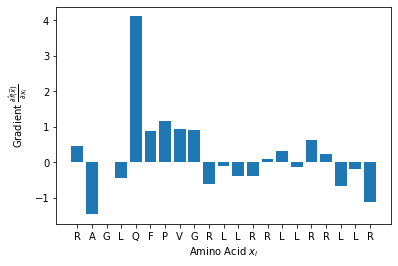

In [13]:
gradient = jax.grad(predict, 0)
g = gradient(sm)
plot_grad(g, s)

Remember that the model outputs logits. Positive value of the gradient mean this amino acid is responsible for pushing hemolytic probability higher and negative values mean the amino acid is pushing towards non-hemolytic. Interestingly, you can see a strong position dependence on the leucine (L) and arginine (R).

### 1.2. Integrated gradient

We’ll now implement the integrated gradients method. We go through three basic steps:
1. Create an array of inputs going from baseline to input peptide
2. Evaluate gradient on each input
3. Compute the sum of the gradients and multiply it by difference between baseline and peptide

The baseline for us is all zeros – which gives a probability of 0.5 (logits = 0, a model root). 

In [14]:
def integrated_gradients(sm, N):
    baseline = jnp.zeros((1, L, 21))
    t = jnp.linspace(0, 1, N).reshape(-1, 1, 1)
    path = baseline * (1 - t) + sm * t

    def get_grad(pi):
        # compute gradient
        # add/remove batch axes
        return gradient(pi[jnp.newaxis, ...])[0]

    gs = jax.vmap(get_grad)(path)
    # sum pieces (Riemann sum), multiply by (x - x')
    ig = jnp.mean(gs, axis=0, keepdims=True) * (sm - baseline)
    return ig


ig = integrated_gradients(sm, 1024)

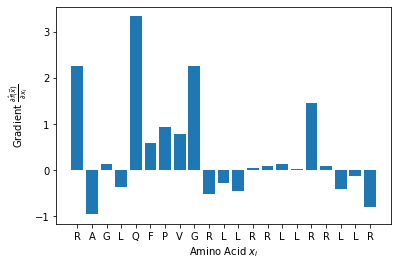

In [15]:
plot_grad(ig, s)

We see that the position dependence has become more pronounced, with arginine being very sensitive to position. Relatively little has qualitatively changed between this and the vanilla gradients.

### 1.3. SmoothGrad

To do SmoothGrad, our steps are almost identicial:
1. Create an array of inputs that are random pertubations of the input peptide
2. Evaluate gradient on each input
3. Compute the mean of the gradients

There is one additional hyperparameter, $\sigma$, which in principle should be as small as possible while still causing the model output to change.

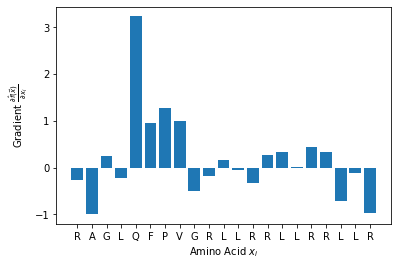

In [16]:
def smooth_gradients(sm, N, rng, sigma=1e-3):
    baseline = jnp.zeros((1, L, 21))
    t = jax.random.normal(rng, shape=(N, sm.shape[1], sm.shape[2])) * sigma
    path = sm + t
    # remove examples that are negative and force summing to 1
    path = jnp.clip(path, 0, 1)
    path /= jnp.sum(path, axis=2, keepdims=True)

    def get_grad(pi):
        # compute gradient
        # add/remove batch axes
        return gradient(pi[jnp.newaxis, ...])[0]

    gs = jax.vmap(get_grad)(path)
    # mean
    ig = jnp.mean(gs, axis=0, keepdims=True)
    return ig


sg = smooth_gradients(sm, 1024, jax.random.PRNGKey(0))
plot_grad(sg, s)

It looks remarkably similar to the vanilla gradient setting – probably because our 1D input/shallow network is not as sensitive to shattered gradients.

## 1.4. Shapley Value

Now we will approximate the Shapley values for each feature using Equation 10.9. The Shapley value computation is different than previous approaches because it does not require gradients. The basic algorithm is:
1. select random point x’
2. create point z by combining x and x’
3. compute change in predicted function

One efficiency change we make is to prevent modifying the sequence in its padding – basically prevent exploring making the sequence longer.

In [17]:
def shapley(i, sm, sampled_x, rng, model):
    M, F, *_ = sampled_x.shape
    z_choice = jax.random.bernoulli(rng, shape=(M, F))
    # only swap out features within length of sm
    mask = jnp.sum(sm[..., 1:], -1)
    z_choice *= mask
    z_choice = 1 - z_choice
    # construct with and w/o ith feature
    z_choice = z_choice.at[:, i].set(0.0)
    z_choice_i = z_choice.at[:, i].set(1.0)
    # select them via multiplication
    z = sm * z_choice[..., jnp.newaxis] + sampled_x * (1 - z_choice[..., jnp.newaxis])
    z_i = sm * z_choice_i[..., jnp.newaxis] + sampled_x * (
        1 - z_choice_i[..., jnp.newaxis]
    )
    v = model(z_i) - model(z)
    return jnp.squeeze(jnp.mean(v, axis=0))


# assume data is alrady shuffled, so just take M
M = 4096
sl = len(s)
sampled_x = train_data.unbatch().batch(M).as_numpy_iterator().next()[0]
# make batched shapley so we can compute for all features
bshapley = jax.vmap(shapley, in_axes=(0, None, None, 0, None))
sv = bshapley(
    jnp.arange(sl),
    sm,
    sampled_x,
    jax.random.split(jax.random.PRNGKey(0), sl),
    predict,
)

# compute global expectation
eyhat = 0
for xi, yi in full_data.batch(M).as_numpy_iterator():
    eyhat += jnp.mean(predict(xi))
eyhat /= len(full_data)

One nice check on Shapley values is that we can check that their sum is equal to the value of model function minus the expect value across all instances. Note we made approximations to use the Equation from so that we cannot expect perfect agreement. That value is computed as:

In [18]:
print(np.sum(sv), predict(sm))

6.785806 8.089269


Finally we can view the individual Shapley values, which is our explanation.

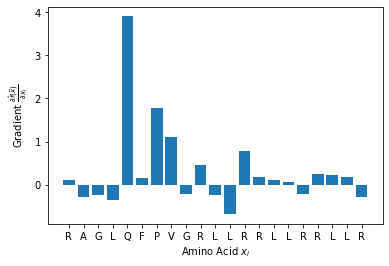

In [19]:
plot_grad(sv, s)

The four methods are shown side-by-side below.

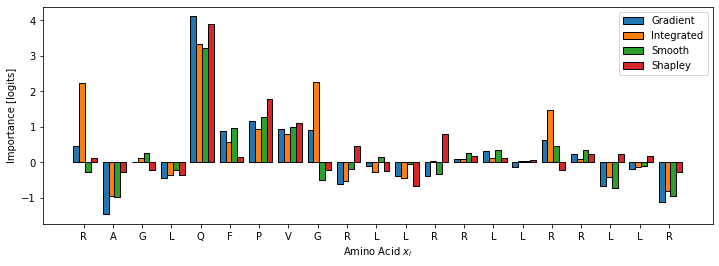

In [20]:
heights = []
plt.figure(figsize=(12, 4))
x = np.arange(len(s))
for i, (gi, l) in enumerate(zip([g, ig, sg], ["Gradient", "Integrated", "Smooth"])):
    h = gi[0, np.arange(len(s)), list(map(ALPHABET.index, s))]
    plt.bar(x + i / 5 - 1 / 4, h, width=1 / 5, edgecolor="black", label=l)
plt.bar(x + 3 / 5 - 1 / 4, sv, width=1 / 5, edgecolor="black", label="Shapley")
ax = plt.gca()
ax.set_xticks(range(len(s)))
ax.set_xticklabels(s)
ax.set_xlabel("Amino Acid $x_i$")
ax.set_ylabel(r"Importance [logits]")
plt.legend()
plt.show()

As someone who works with peptides, I believe the Shapley is the most accurate here. I wouldn’t expect the pattern of L and R to be that significant, which is what the Shapley values show. Another difference is that the Shapley values do not show the phenylalanine (F) as have a significant effect.

What can we conclude from this information? We could perhaps add an explanation like this: “The sequence is predicted to be hemolytic primarily because of the glutamine, proline, and arrangement of lecucine and arginine.”

[Continue discussion](https://dmol.pub/dl/xai.html#what-is-feature-importance-for)

## 2. Finding a Counterfactual

We can quickly implement this idea for our peptide example above. We can define our distance as the Hamming distance. Then the closes $x'$ would be a single amino acid substitution. Let’s just try enumerating those and see if we can achieve a label swap. We’ll define a function that does a single substitution:

In [21]:
def check_cf(x, i, j):
    # copy
    x = jnp.array(x)
    # substitute
    x = x.at[:, i].set(0)    # Change the original one-hot vector of the AA to 0s
    x = x.at[:, i, j].set(1) # Change one of the values of the vector to 1 to change the AA
    return predict(x)


check_cf(sm, 0, 0)

DeviceArray(8.560633, dtype=float32)

Then build all possible substitutions with `jnp.meshgrid` and apply our function over that with `vmap. .ravel()` makes our array of indices be a single dimensions, so we do not need to worry about doing a complex `vmap`.

In [22]:
ii, jj = jnp.meshgrid(jnp.arange(sl), jnp.arange(21))
ii, jj = ii.ravel(), jj.ravel()
x = jax.vmap(check_cf, in_axes=(None, 0, 0))(sm, ii, jj)

Now we’ll display all the single amino acid substitutions which resulted in a negative prediction - the logits are less than zero.

In [23]:
from IPython.core.display import display, HTML

out = ["<tt>"]
for i, j in zip(ii[jnp.squeeze(x) < 0], jj[jnp.squeeze(x) < 0]):
    out.append(f'{s[:i]}<span style="color:red;">{ALPHABET[j]}</span>{s[i+1:]}<br/>')
out.append("</tt>")
display(HTML("".join(out)))

/tmp/ipykernel_8602/1877366075.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


We have a few to choose from, but the interpretation is essentially exchange the glutamine with a hydrophobic group or replace the proline with V, F, A, or C to make the peptide non-hemolytic. Stated as a counterfactual: “If the glutamine were exchanged with a hydrophobic amino acid, the peptide would not be hemolytic”.

[Continue discussion](https://dmol.pub/dl/xai.html#specific-architectures-explanations)

## 3. Summary

- Interpretation of deep learning models is imperative for ensuring model correctness, making predictions useful to humans, and can be required for legal compliance.
- Interpretability of neural networks is part of a broader topic of explainability in AI (XAI), a topic that is in its infancy
- An explanation is still ill-defined, but most often is expressed in terms of model features.
- Strategies for explanations include feature importance, training data importance, counterfactuals, and surrogate models that are locally accurate,
- Most explanations are generated per-example (at inference).
- The most systematic but expensive to compute explanations are Shapley values.
- Some argue that counterfactuals provide the most intuitive and satisfying explanations, but they may not be complete explanations.
- exmol is a software that generate model agnostic molecular counterfactual explanations.
